# Assignment 2 - Basic Machine Learning to predict Pokémon battles results

([From Wikipedia](https://en.wikipedia.org/wiki/Pok%C3%A9mon)) *Pokémon is a Japanese media franchise managed by The Pokémon Company, a company founded by Nintendo, Game Freak, and Creatures. The franchise was created by Satoshi Tajiri in 1996,[4] and is centered on fictional creatures called "Pokémon". In Pokémon, humans, known as Pokémon Trainers, catch and train Pokémon to battle other Pokémon for sport.*

In this assignment we present you a dataset with the results of several Pokémon battles.

Your objective will be to produce a ML model that can predict the outcomes of any Pokémon battle.

At first, in this notebook, you will apply some of the basic ML approaches that we have seen in class. At this point you can also work with the *small* versions of the dataset if you want.

Later, on the `pokemon-competition.ipynb` notebook, you will train a model using all the data that will be used to predict *real* Pokémon battles.

**Dataset Description**

Within the `datasets.zip` file that you can download from the virtual campus, you will find the following datasets:

- data.train -> Full data available to train the models
- data_inverse.train -> Same data as data.train but each combat is seen from the other player's perspective (i.e. pokemon1 becomes pokemon2 and viceversa)
- small.train -> Subsample of data.train to allow fast prototyping
- small_inverse.train -> Subsample of data_inverse.train to allow fast prototyping
- data.hidden -> Dataset with no label available
- data_inverse.hidden -> Same as data.hidden but the pokemons are inverted

The datasets *.hidden are the ones used to get the tournament score,
so the true label is unknown. All the other datasets are available to
you to use however you want.

*Gotta Train 'Em All!*

# File reading utility functions and global variables
The following sections include code that allows the following:
1. Install the project requirements
2. Extract the data from the diferent files
3. Utility functions that simplify the data reading from the files
4. Utility function to print model test scores

In [94]:
# !pip install -r requirements.txt

In [95]:
from pathlib import Path
import pandas
import numpy as np
import json

__wd__ = Path("__file__").resolve().parent
datasets_path = __wd__ / "datasets"

data = pandas.read_csv(datasets_path / "data.train", index_col=0)
inverse_data = pandas.read_csv(datasets_path / "data_inverse.train", index_col=0)

def get_Xy(dataset):
    return dataset.drop("Wins", axis=1), dataset["Wins"]

X, y = get_Xy(data)

In [96]:
# Get the list of opposite lables with the current ones
def add_opposite_labels(labels):
    rt = list(labels)
    for l in labels:
        rt.append(opposite_label(l))
    return rt

# Get the list of opposite lables
def get_opposite_labels(labels):
    return [
        opposite_label(l)
        for l in labels
    ]

# Get current labels and opposite ones, to iterate them separetly
def double_opposite_labels(labels):
    return labels, get_opposite_labels(labels)

# Get Opposite of label
def opposite_label(label):
    other = '__other'
    if label.endswith(other):
        return label[:-len(other)]
    return f'{label}{other}'

# Remove prefix from string
def remove_prefix(text, prefix):
    if text.startswith(prefix):
        return text[len(prefix):]
    return text

SEED = 42

In [97]:
from sklearn.model_selection import cross_val_score
# Determine number of folds for cross validation
FOLDS = 5

def determine_cross_score(predictor, X_data, y_data, folds=FOLDS):
    results = cross_val_score(predictor, X_data, y_data, cv=folds)
    final_score = sum(results) / folds
    print(predictor.__class__.__name__, "score:", final_score)

## Part 1 - Analyze the dataset (2 points)
The first step of any ML process is to know the data we are dealing with. In this part, you have to analyze the dataset and answer the questions below.

1. Which features are categorical? Which are continuous?

In [98]:
'''
CATEGORICAL: 
    Name, Type1, Type2, Legendary, Generation
    Name_other, Type1__other, Type2__other, Legendary__other, Generation__other
CONTINOUS:
    HP, Attack, Defense, Sp. Atk, Sp. Def, Speed,
    HP_other, Attack__other, Defense__other, Sp. Atk__other, Sp. Def__other, Speed__other
NOTE: We consider generation because the domain of the value is fixed and the generations, even though ordered, do not necessarily follow from a continous analysis.
That being said, someone else may consider them continous because they do have order.
'''
list(X.columns)

['Name',
 'Type 1',
 'Type 2',
 'HP',
 'Attack',
 'Defense',
 'Sp. Atk',
 'Sp. Def',
 'Speed',
 'Generation',
 'Legendary',
 'Name__other',
 'Type 1__other',
 'Type 2__other',
 'HP__other',
 'Attack__other',
 'Defense__other',
 'Sp. Atk__other',
 'Sp. Def__other',
 'Speed__other',
 'Generation__other',
 'Legendary__other']

2. Observe the distribution of the "Type 1" variable. Use a plot to show this distribution.

<AxesSubplot: >

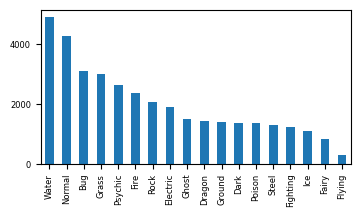

In [99]:
"""
From the plot shown below, we can observe that the pokemon type_1 attributes are not balanced,
we cannot determine if it is due to the natural distribution of pokemon types or if
the dataset lacks information regarding combats containing certain pokemon types.
"""
X['Type 1'].value_counts().plot(kind='bar', figsize=(4,2), fontsize=6)

3. Determine which of the features have missing values. How many missing values there are for each one?

In [100]:
"""  
Type 2 and Type 2__other will be descarted from this analysis as not all pokemons have 2 types

Aproximately, there are 4000 missing values per column, that is about a 10% of missing data per column
"""
X.isna().sum()

Name                  3994
Type 1                3974
Type 2               20535
HP                    4006
Attack                3897
Defense               4034
Sp. Atk               3920
Sp. Def               3982
Speed                 3972
Generation            3993
Legendary             3981
Name__other           3963
Type 1__other         4010
Type 2__other        20594
HP__other             4105
Attack__other         3995
Defense__other        4016
Sp. Atk__other        4096
Sp. Def__other        4005
Speed__other          4044
Generation__other     3986
Legendary__other      3982
dtype: int64

4. Analize the distribution of the target column. Is it balanced?

Total target
False    21152
True     18848
Name: Wins, dtype: int64

Percentage target
False    0.5288
True     0.4712
Name: Wins, dtype: float64


<AxesSubplot: >

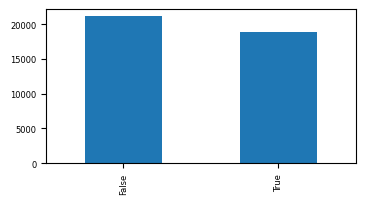

In [101]:
""" 
The distribution of the target column is not perfectly balanced as it has a 3% deviation
However, this small deviation would not suggest any amjor bias, therefore, we consider it balanced. 
"""

print('Total target')
print(y.value_counts())

print('')

print('Percentage target')
print(y.value_counts() / len(y))

y.value_counts().plot(kind='bar', figsize=(4,2), fontsize=6)

## Part 2 - Preprocess the data (3 points)
Once we know how the dataset is, we can proceed with the cleaning of the data. This includes:

- Select the features that you want to use (p.e. removing too specific features). Explain why each feature is used or discarded.
- Impute the missing values. Explain why you use this imputer and not another one. If you use different imputers for different features, explain the reason why you do this.
- Encode the values of the features to work with the model you choose. This can be either encoding the categorical values, or discretizing continuous values.

Numerical correlation


<AxesSubplot: >

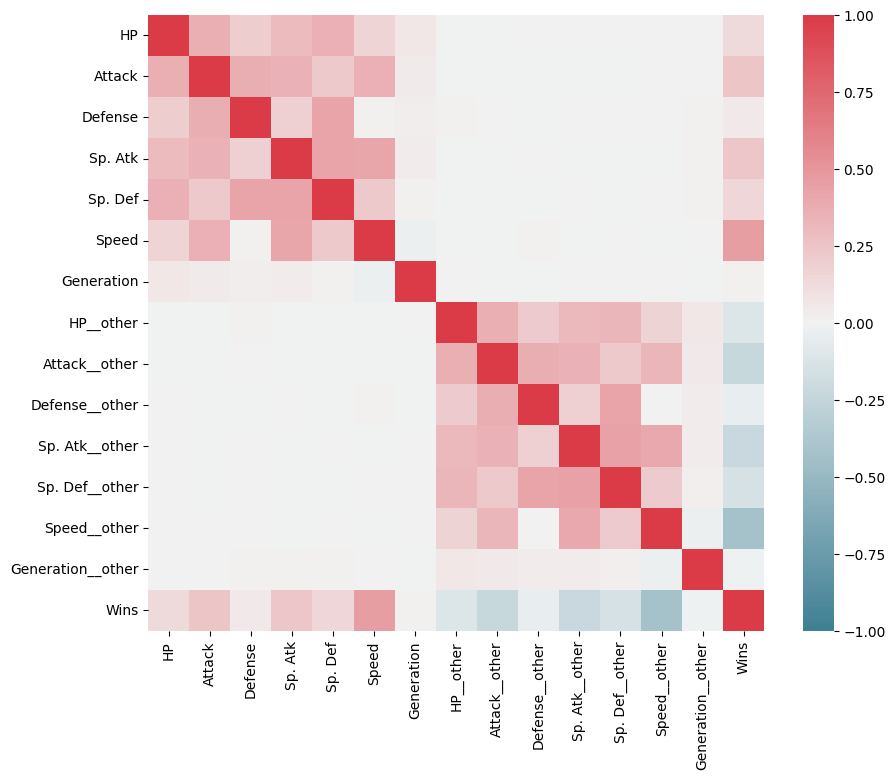

In [102]:
""" 
In order to select the features that will be used for our models, we will use the information
obtained from the following correlation matrix and metrics generated based on the provided values
and ingame knowleadge.
"""
import seaborn as sns
import matplotlib.pyplot as pl

f, ax = pl.subplots(figsize=(10, 8))
num_corr = data[['HP',
                 'Attack',
                 'Defense',
                 'Sp. Atk',
                 'Sp. Def',
                 'Speed',
                 'Generation',            
                 'HP__other',
                 'Attack__other',
                 'Defense__other',
                 'Sp. Atk__other',
                 'Sp. Def__other',
                 'Speed__other',
                 'Generation__other',
                 'Wins']].corr(numeric_only=True)

print("Numerical correlation")
sns.heatmap(num_corr,
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            vmin=-1.0, vmax=1.0,
            square=True, ax=ax)

### Correlation analysis and attribute selection
From the above correlation matrix we can see that the attributes have the following order of importance:
1. Speed
2. Attack, Sp. Attack
3. Sp. Def, HP
4. Defense

As types have an ingame interaction with the Attack, Sp. Attack, Defense and Sp. Defense as they act as multipliers we will also be preserving this information.

On the other side we can see that generation has no correlation with the wins. Additionaly the name of the pokemon is an attribute to specific and we will discard it's use.

In [103]:
'''
There is certain information that can be deduced directly from the name of a Pokemon
This information is:
  - The stats of the Pokemon
  - Types of the Pokemon
  - Other data such as if the Pokemon is legendary, the generation etc.
This allows us to predict aprox 90% of the missing information for the columns that can be deduced from the Pokemon's Name
'''
class DeduceFeaturesFromNameTransformer:
    # We are going to the deduce
    # information about these attributes:
    deduce_from_name = ['Type 1', 'Legendary', 'Generation']
    def __init__(self):
        self.fitted_data = {}
    
    def fit(self, X, y=None):
        for col in self.deduce_from_name:
            self.fit_column(X, col)
        return self
    
    def fit_column(self, X, column):
        name_type = X[add_opposite_labels(['Name', column])].dropna()
        column_data = {}
        for n, t in double_opposite_labels(['Name', column]):
            column_data.update(dict(zip(name_type[n],name_type[t])))

        to_add = {}
        for k, v in column_data.items():
            k = remove_prefix(k, 'Mega ')
            if k not in column_data:
                to_add[k] = v
        column_data.update(to_add)
        self.fitted_data[column] = column_data

    def transform_column(self, X, column):
        for n, t in double_opposite_labels(['Name', column]):
            filler = X.apply(lambda row: self.fitted_data[column].get(row[n], None), axis=1)
            X[t] = X[t].fillna(filler)

    def transform(self, X, y=None):
        for col in self.deduce_from_name:
            self.transform_column(X, col)
        return X


In [104]:
# A lot of pokemons do NOT have Type 2, so those numbers are not representative
# We may miss some information otherwise, but we should not fill in random Type 2
# from pokemons around

# We don't want to fill with other imputters these values if they are None at this point

class FillEmptyNonPredictableTransformer:
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        for col in add_opposite_labels(['Name', 'Type 2', 'Type 1']):
            X[col] = X[col].fillna(value='')
        return X

In [105]:
predict_columns = [
    col
    for col in X.columns if '__other' not in col
    if col not in {'Name', 'Type 1', 'Type 2'}
]
name_predict_columns = ['Name'] + predict_columns

columns_other = {
    opposite_label(col): col for col in name_predict_columns
}
name_columns_other = get_opposite_labels(name_predict_columns)


class SpeedDeducerTransformer:
    predict = ['Name', 'Speed']

    def __init__(self):
        self.train_pokemon_speed = None

    def fit(self, X, y=None):
        X = X[add_opposite_labels(self.predict)]
        first_half = X[self.predict]
        second_half = X[get_opposite_labels(self.predict)]
        second_half = second_half.rename(columns=columns_other)
        unified_pokemons = pandas.concat([first_half, second_half])

        self.train_pokemon_speed = unified_pokemons[unified_pokemons.notna().any(axis=1)]
        print('Len named pokemon nan: ', len(self.train_pokemon_speed.index))
        return self

    def transform(self, X, y=None):
        def expected_speed(row):
            name = row['Name']
            speed = row['Speed']
            if not np.isnan(speed):
                return speed
            same_name = self.train_pokemon_speed[self.train_pokemon_speed['Name'] == name]
            if len(same_name.index) == 0:
                # print('no matching')
                return np.nan
            # print('matching')
            return same_name['Speed'].mean()

        X['Speed'] = X.apply(expected_speed, axis=1)
        return X


In [106]:
'''
Abstract transformer that enables to correct and have a consensus of attributes
for each unique pokemon
'''
class BasePokemonDataCorrectorTransformer:

    def __init__(self, attr):
        self.trained_attrs = {}
        self.attr_to_process = attr #['Name'].extend(attr)

    '''
    This function should generate and return all values needed to store to
    properly proccess a correction in the transform step.
    Recieves the selected attr column data
    '''
    def generate_correction_data(self, data):
        return NotImplementedError

    '''
    This function should determine and if needed correct a value from the
    current attr being looked using the correction data generated before.
    Recieves the value being processed and the correction data needed
    '''
    def process_correction(self, value, data):
        return NotImplementedError

    '''
    Joins both combating pokemons into a unique set in order to proccess all 
    attributes of a known pokemon at the same time
    '''
    def combine_pokemons(self, X, y=None):
        X = X[add_opposite_labels(self.attr_to_process)]
        first_half = X[self.attr_to_process]
        second_half = X[get_opposite_labels(self.attr_to_process)]
        second_half = second_half.rename(columns=columns_other)
        return pandas.concat([first_half, second_half])

    def fit(self, X, y=None):
        unified_pokemons = self.combine_pokemons(X, y)
        for name in unified_pokemons['Name'].unique():
            selected_pokemon = unified_pokemons[unified_pokemons['Name'] == name]
            self.trained_attrs[name] = {}
            for attr in self.attr_to_process[1:]:
                selected_attr = selected_pokemon[selected_pokemon[attr].notna()][attr]
                if len(selected_attr.index) == 0:
                    continue
                self.trained_attrs[name][attr] = self.generate_correction_data(selected_attr)
        return self

    def transform(self, X, y=None):
        def correct_attr(row, attr):
            name = row['Name']
            attr_value = row[attr]
            if name not in self.trained_attrs or attr not in self.trained_attrs[name]:
                return attr_value
            return self.process_correction(attr_value, self.trained_attrs[name][attr])

        for attr in self.attr_to_process[1:]:
            X[attr] = X.apply(lambda row: correct_attr(row, attr), axis=1)
        return X

In [107]:
'''
This class aims to correct data regarding all categorical columns specified in the predict variable.
In order to correct the data we are pursuing to correct all data missing or misslabeled with the mode of the column
*In case there are 2 values with the same mode, we will accept the first one as valid
'''
class CategoricalConsensusTransformer(BasePokemonDataCorrectorTransformer):
    # Overrides not implemented function
    def generate_correction_data(self, data):
        return data.mode()[0]

    # Overrides not implemented function
    def process_correction(self, value, data):
        def is_wrong(value, mode):
            return value == None or value != mode

        mode = data
        if not is_wrong(value, mode):
            return value
        return mode

In [108]:
class NumericConsensusTransformer(BasePokemonDataCorrectorTransformer):
    # Overrides not implemented function
    def generate_correction_data(self, data):
        q1 = data.quantile(0.25)
        mean = data.mean()
        q3 = data.quantile(0.75)
        iqr = q3 - q1
        max = 1.5 * iqr + q3
        min = q1 - 1.5 * iqr
        return (min, mean, max)

    # Overrides not implemented function
    def process_correction(self, value, data):
        def is_wrong(value, min, max):
            return np.isnan(value) or value > max or value < min

        min, mean, max = data
        if not is_wrong(value, min, max):
            return value
        return mean

In [109]:
class BothSidesTransformer:
    def __init__(self, imputer):
        self.imputer = imputer
    
    def get_halfs(self, X):
        first_half = X[predict_columns]
        second_half = X[get_opposite_labels(predict_columns)]
        second_half = second_half.rename(columns=columns_other)
        return first_half, second_half

    def fit(self, X, y=None):
        first_half, second_half = self.get_halfs(X)
        self.imputer.fit(pandas.concat([first_half, second_half]))
        return self
    
    def transform(self, X, y=None):
        first_half, second_half = self.get_halfs(X)
        first_half_predict = self.imputer.transform(first_half)
        second_half_predict = self.imputer.transform(second_half)
        X[predict_columns] = first_half_predict
        X[get_opposite_labels(predict_columns)] = second_half_predict
        return X

In [110]:
from sklearn.impute import KNNImputer, SimpleImputer

class KNNImputerBothSidesTransformer(BothSidesTransformer):
    def __init__(self):
        super().__init__(KNNImputer(n_neighbors=2, weights='distance'))

class SimpleImputterBothSidesTransformer(BothSidesTransformer):
    def __init__(self):
        super().__init__(SimpleImputer(strategy='mean'))

In [111]:
class AddPokemonRatiosTransformer:
    def __init__(self):
        with open('type-chart.json') as f:
            self.type_matrix = json.load(f)

    def map_row_attack_multipler(self, row, opposite):
        all_type_row = ['Type 1', 'Type 2']
        if opposite:
            type_row = get_opposite_labels(all_type_row)
        else:
            type_row = all_type_row
        best_attack_multiplier = 0.25
        at_least_one_type = False
        for attack_type in type_row:
            attack_type = row[attack_type].lower()
            if not attack_type: continue
            multiplier = 1
            for defense_type in all_type_row:
                enemy_defense = defense_type if opposite else opposite_label(defense_type)
                defense_type = row[enemy_defense].lower()
                if not defense_type: continue
                multiplier *= self.type_matrix[attack_type][defense_type]
                at_least_one_type = True
            best_attack_multiplier = max(best_attack_multiplier, multiplier)
        if not at_least_one_type:
            return 1
        return best_attack_multiplier

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        clean_ratios = X[add_opposite_labels(['Attack', 'Defense', 'Sp. Atk', 'Sp. Def'])]
        clean_ratios = X.replace(0, 1)
        tmp_rows = {}
        for side in [True, False]:
            ot_label = '', '__other'
            if not side:
                ot_label = ot_label[::-1]
            first_label, second_label = ot_label
            at_def_ratio = X[f'Attack{first_label}'] / clean_ratios[f'Defense{second_label}']
            sp_at_def_ratio = X[f'Sp. Atk{first_label}'] / clean_ratios[f'Sp. Def{second_label}']
            best_ratio = pandas.concat([at_def_ratio, sp_at_def_ratio], axis=1).max(axis=1)
            X[f'best_attack_ratio{first_label}'] = best_ratio

            
            tmp_rows[f'is_mega{first_label}'] = X[f'Name{first_label}'].str.contains('Mega ', regex=False).astype(int)
            stat_sum = X[[f'HP{first_label}', f'Attack{first_label}' , f'Defense{first_label}' , f'Sp. Atk{first_label}' ,f'Sp. Def{first_label}' ,f'Speed{first_label}']].sum(axis=1)
            tmp_rows[f'sum_stats{first_label}'] = stat_sum

        X['attack_multiplier'] = X.apply(lambda row: self.map_row_attack_multipler(row, opposite=False),axis=1)
        X[opposite_label('attack_multiplier')] = X.apply(lambda row: self.map_row_attack_multipler(row, opposite=True),axis=1)
        X['attack_multipler_diff'] = X['attack_multiplier'] - X[opposite_label('attack_multiplier')]
        X['sum_stats_diff'] = tmp_rows['sum_stats'] - tmp_rows[opposite_label('sum_stats')]
        X['HP_diff'] = X['HP'] - X[opposite_label('HP')]
        X['HP_attack'] = X['HP'] / X[opposite_label('attack_multiplier')]
        X[opposite_label('HP_attack')] = X[opposite_label('HP')] / X['attack_multiplier']
        X['HP_attack_diff'] = X['HP_attack'] - X[opposite_label('HP_attack')]
        X['HP_attack_multiplier_diff'] = X['attack_multipler_diff'] * X['HP_diff']
        X['mega_diff'] = tmp_rows['is_mega'] - tmp_rows[opposite_label('is_mega')]
        X['strong_pokemon'] = X['mega_diff'] + X['Legendary'] - X[opposite_label('Legendary')]
        X['velocity_diff'] =  (X['Speed'] - X['Speed__other'])
        X['velocity_diff_binary'] =  (X['Speed'] - X['Speed__other']) < 0
        return X

In [112]:
from sklearn.base import BaseEstimator, TransformerMixin

class IdentityTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X

## Part 3 - Training your model (3 points)
In this part you have to train a **classifier** model to predict if a Pokemon will win or not a battle against another Pokemon. For this, you should explore at least 3 different classifiers.

You have to train and evaluate those classifiers using cross-validation in order to select the best one. Then, you should also study the results of the model (overfit, underfit, possible bias...).

1. Train (at least) 3 different classifiers
2. Evaluate the 3 classifiers using cross-validation. Select the best model according to this metric.
3. For the selected model: 
   1. Get the accuracy for data not seen during the training process
   2. Plot the confusion matrix
   3. Analize the results of accuracy and the confusion matrix

In [113]:
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder

CATEGORICAL = add_opposite_labels(['Type 1', 'Type 2', 'Legendary'])
NUMERIC = add_opposite_labels(['HP', 'Attack', 'Defense', 'Sp. Atk',
                               'Sp. Def', 'Speed', 'Generation', 'best_attack_ratio',
                               'attack_multiplier', 'HP_attack']) + \
    ['attack_multipler_diff', 'sum_stats_diff', 'HP_diff', 'mega_diff',
     'HP_attack_diff', 'HP_attack_multiplier_diff',
     'strong_pokemon', 'velocity_diff', 'strong_pokemon']
BINARY = ['mega_diff', 'velocity_diff_binary'] + \
    add_opposite_labels(['Legendary'])

pre_pipeline = Pipeline(
    [
        ("data-correction", make_pipeline(
            DeduceFeaturesFromNameTransformer(),
            FillEmptyNonPredictableTransformer(),
            # adjust known values as there may be outfliers that add noise to the general expected behaviour
            NumericConsensusTransformer(
                ['Name', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']),
            CategoricalConsensusTransformer(
                ['Name', 'Legendary']),
            # KNN Imputer is better than the Simple Imputter, but way slower
            # deduce missing data from the adjusted values
            KNNImputerBothSidesTransformer(),
            # ('simple', SimpleImputterBothSidesTransformer()),
        )),
        ("data-enchancement", Pipeline(
            [
                # create retio values that take into account in-game mechanics
                # from the raw data
                ("generate_ratios", AddPokemonRatiosTransformer())
            ]
        )),
        ("column-transform", ColumnTransformer(
            [
                (
                    "cat",
                    OneHotEncoder(sparse_output=True,
                                  handle_unknown='ignore'),
                    CATEGORICAL
                ),
                ("scaler", StandardScaler(), NUMERIC),
                ("binary", KBinsDiscretizer(n_bins=2,
                                            encode='onehot-dense', strategy='kmeans'), BINARY)
            ],
            remainder="drop",
        ))
    ]
)


In [114]:
from sklearn.model_selection import train_test_split
test_size_pctg = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size_pctg, random_state=SEED)

print(X.shape, X_train.shape, X_test.shape)
print(y.shape, y_train.shape, y_test.shape)

(40000, 22) (32000, 22) (8000, 22)
(40000,) (32000,) (8000,)


In [115]:
pre_pipeline.fit(X_train)

Pipeline(steps=[('data-correction',
                 Pipeline(steps=[('deducefeaturesfromnametransformer',
                                  <__main__.DeduceFeaturesFromNameTransformer object at 0x0000022F3CBAA010>),
                                 ('fillemptynonpredictabletransformer',
                                  <__main__.FillEmptyNonPredictableTransformer object at 0x0000022F3CBA9490>),
                                 ('numericconsensustransformer',
                                  <__main__.NumericConsensusTransformer object at 0x0...
                                                   'attack_multiplier__other',
                                                   'HP_attack__other',
                                                   'attack_multipler_diff',
                                                   'sum_stats_diff', 'HP_diff',
                                                   'mega_diff',
                                                   'HP_attack_diff',
                                                   'HP_attack_multiplier_diff',
                                                   'strong_pokemon',
                                                   'velocity_diff',
                                                   'strong_pokemon']),
                                                 ('binary',
                                                  KBinsDiscretizer(encode='onehot-dense',
                                                                   n_bins=2,
                                                                   strategy='kmeans'),
                                                  ['mega_diff',
                                                   'velocity_diff_binary',
                                                   'Legendary',
                                                   'Legendary__other'])]))])

In [116]:
X_train_encoded = pre_pipeline.transform(X_train)
X_test_encoded = pre_pipeline.transform(X_test)

In [117]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot as plt
from sklearn import tree

dtc_model = DecisionTreeClassifier(criterion="entropy", max_depth=6, min_samples_leaf=5, random_state=SEED)
dtc_model.fit(X_train_encoded, y_train)
'Train Score', dtc_model.score(X_train_encoded, y_train), 'Test Score', dtc_model.score(X_test_encoded, y_test)

('Train Score', 0.8694375, 'Test Score', 0.86625)

In [118]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

rfc_model = RandomForestClassifier(criterion="entropy", max_depth=9, min_samples_leaf=5, random_state=SEED)
rfc_model.fit(X_train_encoded, y_train)
'Train Score', rfc_model.score(X_train_encoded, y_train), 'Test Score', rfc_model.score(X_test_encoded, y_test)

('Train Score', 0.8649375, 'Test Score', 0.862)

In [119]:
from sklearn.neural_network import MLPClassifier

mlp_model = MLPClassifier(hidden_layer_sizes=(6, 4, 2), max_iter=1000, random_state=SEED)
mlp_model.fit(X_train_encoded, y_train)
'Train Score', mlp_model.score(X_train_encoded, y_train), 'Test Score', mlp_model.score(X_test_encoded, y_test)

('Train Score', 0.8755625, 'Test Score', 0.867)

In [120]:
# This is incredibly slow and it doesn't even perform that well
# from sklearn.neighbors import KNeighborsClassifier

# knn_model = KNeighborsClassifier()
# knn_model.fit(X_train_encoded, y_train)
# 'Train Score', knn_model.score(X_train_encoded, y_train)

In [121]:
# predict = rfc_model.predict(X_train_encoded)
# different = y_train != predict
# import pandas as pd
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', -1)

# print(X_train.loc[different].iloc[7].astype(str))
# print(y_train.loc[different].iloc[7])

# # AddPokemonRatiosTransformer().map_row_attack_multipler(X_train.loc[different].iloc[0], opposite=True)

### Best model

In [129]:
determine_cross_score(dtc_model, X_test_encoded, y_test)
determine_cross_score(rfc_model, X_test_encoded, y_test)
determine_cross_score(mlp_model, X_test_encoded, y_test)

DecisionTreeClassifier score: 0.860625
RandomForestClassifier score: 0.8614999999999998
MLPClassifier score: 0.8310000000000001


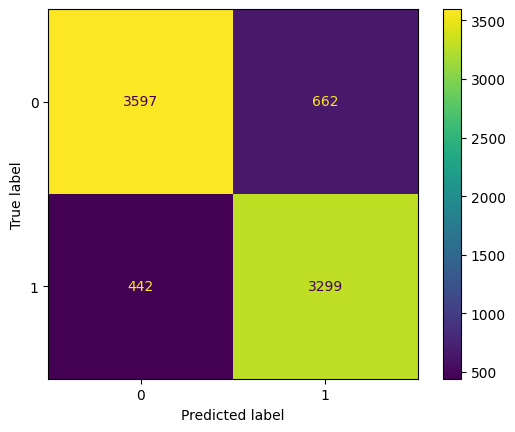

CLASSIFICATION REPORT
              precision    recall  f1-score   support

       False       0.89      0.84      0.87      4259
        True       0.83      0.88      0.86      3741

    accuracy                           0.86      8000
   macro avg       0.86      0.86      0.86      8000
weighted avg       0.86      0.86      0.86      8000

FURTHER METRICS:
Balanced Accuracy score 0.8632071122686307
Precision 0.8328704872506942
Recall 0.8818497727880246


In [137]:
# Generating confusion matrix of the best perfromant model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, classification_report

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = rfc_model.predict(X_test_encoded)

test_conf_matrix = confusion_matrix(y_test, y_pred)
test_disp = ConfusionMatrixDisplay(test_conf_matrix)
test_disp.plot()
plt.show()

print("CLASSIFICATION REPORT")
print(classification_report(y_test, y_pred))

print("FURTHER METRICS:")
print("Balanced Accuracy score", balanced_accuracy_score(y_test, y_pred))
print("Precision", precision_score(y_test, y_pred))
print("Recall", recall_score(y_test, y_pred))

## Part 4 (Optional) - Create an ensemble and configure the model

You have trained different classifiers but selected only one of them as "the best" one. Maybe instead of having the models competing between them, having them to colaborate would yield better results. 

We propose you to create an ensemble of the different classifiers explored in *Part 3*. You should compare the ensemble with the individual models using cross-validation, and then get the final accuracy and the confusion matrix for the ensemble.
As a bonus, try to tune the parameters of this ensemble using either `GridSearchCV` or `RandomizedSearchCV`.

1. Train an ensemble with the classifiers in *Part 3*.
2. Compare the performance of this ensemble using cross-validation, the final accuracy, and the confusion matrix. Analyze the results.
3. Fine-tune the hyper-parameters of the ensemble using `GridSearchCV` or `RandomizedSearchCV`.

### Ensamble
Ensambling the three tested models above benefits us as it increases our overall score.
Regarding the confusion matrix, 

Test Score:
0.868125
VotingClassifier score: 0.858875


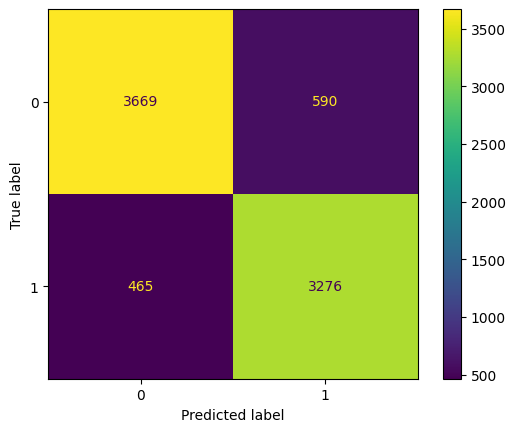

CLASSIFICATION REPORT
              precision    recall  f1-score   support

       False       0.89      0.86      0.87      4259
        True       0.85      0.88      0.86      3741

    accuracy                           0.87      8000
   macro avg       0.87      0.87      0.87      8000
weighted avg       0.87      0.87      0.87      8000

FURTHER METRICS:
Balanced Accuracy score 0.8685857563199813
Precision 0.8473874806001035
Recall 0.8757016840417001


In [135]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, classification_report

eclf = VotingClassifier(estimators=[('dtc', dtc_model), ('rfc', rfc_model), ('mlp', mlp_model)], voting='soft', weights=[1, 2, 2])
eclf.fit(X_train_encoded, y_train)
print("Test Score:")
print(eclf.score(X_test_encoded, y_test))
determine_cross_score(eclf, X_test_encoded, y_test)

y_pred = eclf.predict(X_test_encoded)

r_conf_matrix = confusion_matrix(y_test, y_pred)
test_disp = ConfusionMatrixDisplay(r_conf_matrix)
test_disp.plot()
plt.show()

print("CLASSIFICATION REPORT")
print(classification_report(y_test, y_pred))

print("FURTHER METRICS:")
print("Balanced Accuracy score", balanced_accuracy_score(y_test, y_pred))
print("Precision", precision_score(y_test, y_pred))
print("Recall", recall_score(y_test, y_pred))

### Fine tunning

Randomized Search:
0.87


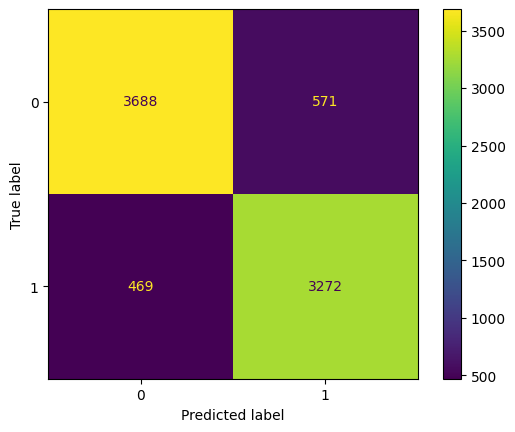

Balanced Accuracy score 0.870281710463726
Precision 0.8514181628935727
Recall 0.8746324512162523
              precision    recall  f1-score   support

       False       0.89      0.87      0.88      4259
        True       0.85      0.87      0.86      3741

    accuracy                           0.87      8000
   macro avg       0.87      0.87      0.87      8000
weighted avg       0.87      0.87      0.87      8000



In [136]:
# As our models have quite a large number of inputs, we are opting to use the RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
parameters = {
    'rfc__n_estimators': list(range(1, 200)),
    'rfc__max_depth': list(range(5, 25)),
    'dtc__max_depth': list(range(5, 25)),
    'mlp__max_iter': list(range(500, 1200)),
}

clf = RandomizedSearchCV(eclf, parameters, cv=5, n_jobs=-1, n_iter=5, random_state=SEED)
clf.fit(X_train_encoded, y_train)
print("Randomized Search:")
print(clf.score(X_test_encoded, y_test))

y_pred =  clf.predict(X_test_encoded)

r_conf_matrix = confusion_matrix(y_test, y_pred)
test_disp = ConfusionMatrixDisplay(r_conf_matrix)
test_disp.plot()
plt.show()

print("Balanced Accuracy score", balanced_accuracy_score(y_test, y_pred))
print("Precision", precision_score(y_test, y_pred))
print("Recall", recall_score(y_test, y_pred))

print(classification_report(y_test, y_pred))

## Part 5 - Wrap-up (2 points)
The final part of this assignment is to wrap-up your classifier into a pipeline. This pipeline will execute the entire process:

- Preprocess the data
    - Select features
    - Impute data
    - Encode values
- The classifier selected in *Part 3* (or the ensemble if it is better)

This pipeline will be used in the other provided notebook to generate the predictions for the combats you have to submit.

To ensure everything works as expected, we recommend you to load the dataset again before using it with the pipeline. You should also compare the accuracy and the confusion matrix from the pipeline with the model trained before. **Remember to set the random state to all the required transformers and estimators to have a constant output**.

In [126]:
predictor = Pipeline([
    ("preprocessing", pre_pipeline),
    ("ensamble", clf)
])

predictor.fit(X_train, y_train)


Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('data-correction',
                                  Pipeline(steps=[('deducefeaturesfromnametransformer',
                                                   <__main__.DeduceFeaturesFromNameTransformer object at 0x0000022F3CBAA010>),
                                                  ('fillemptynonpredictabletransformer',
                                                   <__main__.FillEmptyNonPredictableTransformer object at 0x0000022F3CBA9490>),
                                                  ('numericconsensustransformer',
                                                   <__main__.Numer...
                                                                            23,
                                                                            24],
                                                         'mlp__max_iter': [500,
                                                                           501,
                                                                           502,
                                                                           503,
                                                                           504,
                                                                           505,
                                                                           506,
                                                                           507,
                                                                           508,
                                                                           509,
                                                                           510,
                                                                           511,
                                                                           512,
                                                                           513,
                                                                           514,
                                                                           515,
                                                                           516,
                                                                           517,
                                                                           518,
                                                                           519,
                                                                           520,
                                                                           521,
                                                                           522,
                                                                           523,
                                                                           524,
                                                                           525,
                                                                           526,
                                                                           527,
                                                                           528,
                                                                           529, ...],
                                                         'rfc__max_depth': [5,
                                                                            6,
                                                                            7,
                                                                            8,
                                                                            9,
                                                                            10,
                                                                            11,
                                                                            12,
                                                                            13,
                                               